# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [110]:
# import libraries
from pyspark.sql import SparkSession

In [111]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import greatest
from pyspark.sql.functions import col
from pyspark.sql.functions import *

import datetime

from pyspark.sql import Window
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import re
from pyspark.sql import functions as sF
from pyspark.sql import types as sT

from functools import reduce


In [112]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [4]:
# Extract data
!tar chvfz notebook.tar.gz *

Sparkify-zh.ipynb
Sparkify.ipynb
data/
data/sparkify_model_vf.csv/
data/sparkify_model_vf.csv/.part-00144-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv.crc
data/sparkify_model_vf.csv/part-00036-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv
data/sparkify_model_vf.csv/part-00167-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv
data/sparkify_model_vf.csv/part-00085-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv
data/sparkify_model_vf.csv/.part-00169-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv.crc
data/sparkify_model_vf.csv/part-00083-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv
data/sparkify_model_vf.csv/part-00116-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv
data/sparkify_model_vf.csv/.part-00016-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv.crc
data/sparkify_model_vf.csv/.part-00105-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv.crc
data/sparkify_model_vf.csv/part-00049-e6bc52a1-514c-435e-aa3c-aa5e042bc686-c000.csv
data/sparkify_model_vf.csv/_SUCCESS
data/sparkify_model_vf.csv/part-00055

In [5]:
data_path = 'mini_sparkify_event_data.json'
df = spark.read.json(data_path)
# See the frame schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [6]:
# reading the first few rows
df.take(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [7]:
# checking the column types
df.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [8]:
df.describe().show()

+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|summary|            artist|      auth|firstName|gender|     itemInSession|lastName|           length| level|         location|method|   page|        registration|        sessionId|                song|            status|                  ts|           userAgent|           userId|
+-------+------------------+----------+---------+------+------------------+--------+-----------------+------+-----------------+------+-------+--------------------+-----------------+--------------------+------------------+--------------------+--------------------+-----------------+
|  count|            228108|    286500|   278154|278154|            286500|  278154|           228108|286500|           278154|286500| 286500|            

In [9]:
# Total count of artists
df.describe("artist").show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [10]:
#total count of sessionIds
df.describe("sessionId").show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [11]:
#Overall count
df.count()

286500

In [12]:
#Dropping duplicates
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



### Drop Rows with Missing Values

In [13]:
#retaining only valid rows
df_valid = df.dropna(how = "any", subset = ["userId", "sessionId"])

In [14]:
# counting the number of rows dropped
df_valid.count()

286500

In [15]:
df.count()

286500

In [16]:
# Hence, there are no missing values in the 'UserId' column

In [17]:
df_valid.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [18]:
#Looks like there are rows with null strings and we will need to eliminate these

In [19]:
df_valid = df_valid.filter(df_valid["userId"] != "")

In [20]:
# counting the total number of rows
df_valid.count()

278154

In [21]:
#Hence, we dropped 
df.count() - df_valid.count()

8346

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Churn Definition
A user is defined as churned when there's an event called Cancellation Confirmation appeared in activity log. This event happens for both paid and free users.

In [22]:
#Creating a flag for churn
churn_users = df_valid.filter(df.page=="Cancellation Confirmation").select("userId").dropDuplicates()
churn_users_list = [(row['userId']) for row in churn_users.collect()]
df_valid = df_valid.withColumn("churn", df_valid.userId.isin(churn_users_list))

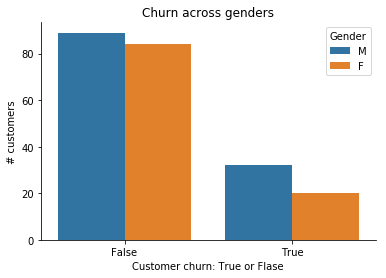

In [23]:
# Seeing who churned more: Males or Females?

gender_churn_pd = df_valid.dropDuplicates(["userId", "gender"]).groupby(["churn", "gender"]).count().sort("churn").toPandas()

ax = sns.barplot(x='churn', y='count', hue='gender', data=gender_churn_pd)
plt.xlabel('Customer churn: True or Flase')
plt.ylabel('# customers')
plt.legend(title='Gender', loc='best')
plt.title('Churn across genders')
sns.despine(ax=ax);

#### Observation:
_Male customers are likely to churn more than Female customers_

In [24]:
# add a time column to df
convert_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df_valid = df_valid.withColumn('event_time', convert_ts('ts'))
df_valid = df_valid.withColumn('registration_time', convert_ts('registration'))

#### Looking at Male and Female customers across their lifetime

In [25]:
# total number of songs listened over a customer's lifetime
lifetime_pd = df_valid.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churn', 'gender', 'page']).count().toPandas()
lifetime_pd = lifetime_pd.pivot_table(index=['userId','churn','gender'], values='count', columns='page').reset_index()

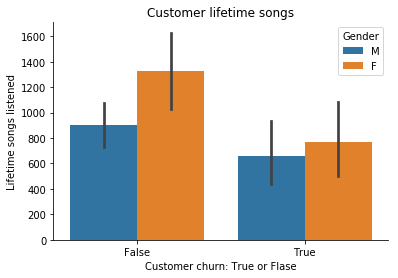

In [26]:
#bar plot for a better representation of #songs over lifetime across both genders
ax = sns.barplot(data=lifetime_pd, x='churn', y='NextSong', hue='gender')
plt.xlabel('Customer churn: True or Flase')
plt.ylabel('Lifetime songs listened')
plt.legend(title='Gender', loc='best')
plt.title('Customer lifetime songs')
sns.despine(ax=ax);

#### Observation:
_Female customers seem to use the service many more times than male customers_

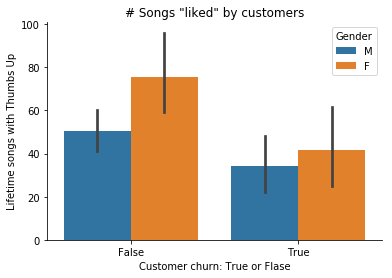

In [27]:
#bar plot for a better representation of #songs liked over lifetime across both genders
ax = sns.barplot(data=lifetime_pd, x='churn', y='Thumbs Up', hue='gender')
plt.xlabel('Customer churn: True or Flase')
plt.ylabel('Lifetime songs with Thumbs Up')
plt.legend(title='Gender', loc='best')
plt.title('# Songs "liked" by customers')
sns.despine(ax=ax);

#### Observation:
_Female customers review the songs more than male customers_

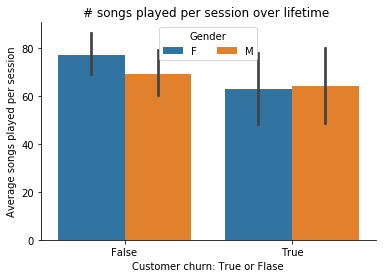

In [28]:
#bar plot for a number of songs played per session over lifetime across both genders
songs_gender_pd = df_valid.where('page == "NextSong"').groupby(['churn', 'userId', 'sessionId','gender']).count()\
    .groupby(['churn', 'userId', 'gender']).agg({'count':'avg'})\
    .withColumnRenamed('avg(count)', 'avg_songs_played')\
    .toPandas()

ax = sns.barplot('churn', y='avg_songs_played', hue='gender', data=songs_gender_pd)
plt.xlabel('Customer churn: True or Flase')
plt.ylabel('Average songs played per session')
plt.legend(title='Gender', loc='best', ncol=2)
plt.title('# songs played per session over lifetime ')
sns.despine(ax=ax);

#### Observation:
_Female customers use the service more before churning, whereas, Male customers who continue seem to play marginally more songs_

#### Additional EDA:

#### After how long does a customer churn

In [29]:
# After how long does a customer churn?
lt_pd = df_valid \
    .select('userId','registration','ts','churn') \
    .withColumn('lifetime',((df_valid.ts-df_valid.registration)/1000/3600/24))\
    .groupBy('userId','churn') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', 'churn', 'lifetime')\
    .toPandas()

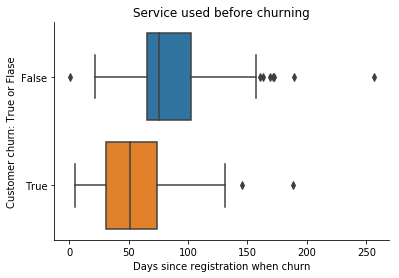

In [30]:
ax = sns.boxplot(data=lt_pd, y='churn', x='lifetime', orient='h')
plt.xlabel('Days since registration when churn')
plt.ylabel('Customer churn: True or Flase')
plt.title('Service used before churning')
sns.despine(ax=ax);

#### Observation:
_Churned customer use the service for a shorter period of time. Hypothesis: Customers quickly realize that the service is not to their liking and de-register quickly_

#### Calculating Statistics by Hour

In [31]:
#count at an hourly level
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [32]:
df = df.withColumn("hour", get_hour(df.ts))

In [33]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', hour='0')

In [34]:
#total number of songs requested by the hour
songs_in_hour = df.filter(df.page == "NextSong").groupby(df.hour).count().orderBy(df.hour.cast("float"))

In [35]:
songs_in_hour.show()

+----+-----+
|hour|count|
+----+-----+
|   0| 9062|
|   1| 8388|
|   2| 8336|
|   3| 8355|
|   4| 8147|
|   5| 8178|
|   6| 8054|
|   7| 8091|
|   8| 8253|
|   9| 8498|
|  10| 8882|
|  11| 8830|
|  12| 9326|
|  13| 9644|
|  14|10494|
|  15|11354|
|  16|11636|
|  17|11460|
|  18|11124|
|  19|10930|
+----+-----+
only showing top 20 rows



In [36]:
# converting to a pandas df for plotting graphs
songs_in_hour_pd = songs_in_hour.toPandas()
songs_in_hour_pd.hour = pd.to_numeric(songs_in_hour_pd.hour)

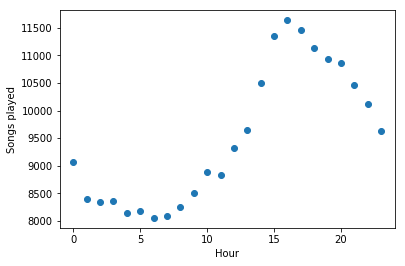

In [37]:
#scatterplot to check when is the next song requested
plt.scatter(songs_in_hour_pd["hour"], songs_in_hour_pd["count"])
plt.xlim(-1, 24);
plt.xlabel("Hour")
plt.ylabel("Songs played");

#### Observation:
_Customers tend to play more songs post lunch (after 2 PM) and it slowly tapers down to 10 PM_

#### Users Downgrade Their Accounts
Find when users downgrade their accounts and then flag those log entries.

In [38]:
df_valid.filter("page = 'Submit Downgrade'").show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+-------------------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|            page| registration|sessionId|song|status|           ts|           userAgent|userId|churn|         event_time|  registration_time|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+----------------+-------------+---------+----+------+-------------+--------------------+------+-----+-------------------+-------------------+
|  null|Logged In|     Kael|     M|           47|    Baker|  null| paid|Kingsport-Bristol...|   PUT|Submit Downgrade|1533102330000|      249|null|   307|1538393619000|"Mozilla/5.0 (Mac...|   131|false|2018-10-01 11:33:39|2018-08-01 05:45:30|
|  null|Logged In|   Calvin|    

In [39]:
#creating a flag
flag_downgrade_event = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())

In [40]:
df_valid = df_valid.withColumn("downgraded", flag_downgrade_event("page"))

In [41]:
df_valid.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', churn=False, event_time='2018-10-01 00:01:57', registration_time='2018-09-28 22:22:42', downgraded=0)

In [42]:
#using windows function for calculating cumulative scores in reverse chronological order for Phase column
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [43]:
df_valid = df_valid.withColumn("phase", Fsum("downgraded").over(windowval))

In [44]:
df_valid.select(["userId", "firstname", "ts", "page", "level", "phase"]).sort("ts").collect()

[Row(userId='30', firstname='Colin', ts=1538352117000, page='NextSong', level='paid', phase=1),
 Row(userId='9', firstname='Micah', ts=1538352180000, page='NextSong', level='free', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352394000, page='NextSong', level='paid', phase=1),
 Row(userId='9', firstname='Micah', ts=1538352416000, page='NextSong', level='free', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352676000, page='NextSong', level='paid', phase=1),
 Row(userId='9', firstname='Micah', ts=1538352678000, page='NextSong', level='free', phase=1),
 Row(userId='9', firstname='Micah', ts=1538352886000, page='NextSong', level='free', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352899000, page='NextSong', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538352905000, page='Add to Playlist', level='paid', phase=1),
 Row(userId='30', firstname='Colin', ts=1538353084000, page='NextSong', level='paid', phase=1),
 Row(userId='9', firstname='Micah', t

In [45]:
df_valid.select("page").dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



#### Perhaps a blank user id represents users who have not signed up yet or who are signed out and are about to log in

In [46]:
# Evaluating #gender users in the data set?
df_valid.groupby("gender").count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [47]:
# It seems like females use this service more than males

#### Understand how many songs were played from the most played artist?

In [48]:
df_valid.filter(df.page == 'NextSong') \
    .select('Artist') \
    .groupBy('Artist') \
    .agg({'Artist':'count'}) \
    .withColumnRenamed('count(Artist)', 'Artistcount') \
    .sort(desc('Artistcount')) \
    .show(5)

+--------------------+-----------+
|              Artist|Artistcount|
+--------------------+-----------+
|       Kings Of Leon|       1841|
|            Coldplay|       1813|
|Florence + The Ma...|       1236|
|       Dwight Yoakam|       1135|
|            BjÃÂ¶rk|       1133|
+--------------------+-----------+
only showing top 5 rows



#### How many songs do users listen to on average between visiting our home page?

In [49]:


function = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum = df_valid.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', function(col('page'))) \
    .withColumn('period', Fsum('homevisit').over(user_window))

cusum.filter((cusum.page == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).show()

+------------------+
|avg(count(period))|
+------------------+
| 23.60389072847682|
+------------------+



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

### We will build the following features:
 - Feature1: Number of days since registration
 - Feature2: Total length of listening
 - Feature3: Session Duration(3 Features: Min, Max and Avg)
 - Feature4: Number of songs per session
 - Feature5: Total number of sessions
 - Feature6: Gender(Male or Female)
 - Feature7: Distinct count of singers
 - Feature8: Churn
 - Feature9: Like (Thumbs up/down)
 - Feature10: Paid or Free user
 - Feature11: Number of songs added to Playlist
 - Feature12: Number of friends added

**Feature1:Number of days since registration**

In [85]:
user_max_ts = df_valid.groupby("userId").max("ts").sort("userId")
user_reg_ts = df_valid.select("userId", "registration").dropDuplicates().sort("userId")
user_reg_days = user_reg_ts.join(user_max_ts, user_reg_ts.userId == user_max_ts.userId).select(user_reg_ts["userId"], ((user_max_ts["max(ts)"]-user_reg_ts["registration"])/(1000*60*60*24)).alias("regDay"))
user_reg_days.fillna(0)

DataFrame[userId: string, regDay: double]

In [86]:
user_reg_days.show(5)

+------+------------------+
|userId|            regDay|
+------+------------------+
|100010| 55.64365740740741|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|   124|131.55591435185184|
|    51|19.455844907407407|
+------+------------------+
only showing top 5 rows



**Feature2: Total length of listening**

In [87]:
length_listening = df_valid \
    .select('userID','length') \
    .groupBy('userID') \
    .sum() \
    .withColumnRenamed('sum(length)', 'listen_time')
    
length_listening.fillna(0)
length_listening.show(5)

+------+------------------+
|userID|       listen_time|
+------+------------------+
|100010| 66940.89735000003|
|200002| 94008.87593999993|
|   125|2089.1131000000005|
|    51| 523275.8428000004|
|   124|1012312.0927899999|
+------+------------------+
only showing top 5 rows



**Feature3: Session Duration(3 Features: Min, Max and Avg)**

In [53]:
df_valid.show(5)

+----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+------+-----+-------------------+-------------------+----------+-----+
|    artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|               song|status|           ts|           userAgent|userId|churn|         event_time|  registration_time|downgraded|phase|
+----------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+-------------------+------+-------------+--------------------+------+-----+-------------------+-------------------+----------+-----+
|      null|Logged In| Darianna|     F|           34|Carpenter|     null| free|Bridgeport-Stamfo...|   PUT|     Logout|1538016340000|      187|               null|   307|15

In [88]:
user_session_time = df_valid.groupby("userId", "sessionId")\
                    .agg(((max(df_valid.ts)-min(df_valid.ts))/(1000*60)).alias("sessionTime"))

In [89]:
user_session_time_stat = user_session_time.groupby("userId")\
                        .agg(avg(user_session_time.sessionTime).alias("avgSessionTime"), min(user_session_time.sessionTime).alias("minSessionTime"), max(user_session_time.sessionTime).alias("maxSessionTime"))

In [90]:
user_session_time_stat.fillna(0)
user_session_time_stat.show(5)

+------+------------------+------------------+------------------+
|userId|    avgSessionTime|    minSessionTime|    maxSessionTime|
+------+------------------+------------------+------------------+
|100010|154.48333333333332|             22.55|             323.0|
|200002|266.40000000000003|              12.1|            497.45|
|   125|29.566666666666666|29.566666666666666|29.566666666666666|
|    51| 872.3566666666666| 67.06666666666666| 2069.383333333333|
|   124| 578.9942528735633|               0.0|1770.6166666666666|
+------+------------------+------------------+------------------+
only showing top 5 rows



**Feature4: Number of songs per session**

In [91]:
user_session_songs = df_valid.filter(df_valid.page=="NextSong")\
                    .groupby("userId", "sessionId")\
                    .count()

In [92]:
user_session_songs_avg = user_session_songs.groupby("userId")\
                        .agg(avg(user_session_songs["count"]).alias("avgSessionSongs"))
                        

In [93]:
user_session_songs_avg.fillna(0)
user_session_songs_avg.show(5)

+------+------------------+
|userId|   avgSessionSongs|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



**Feature5: Total number of sessions**

In [94]:
user_session_count = df_valid.select("userId", "sessionId")\
                    .dropDuplicates()\
                    .groupby("userId")\
                    .count()\
                    .withColumnRenamed("count", "sessionCount")

In [95]:
user_session_count.fillna(0)
user_session_count.show(5)

+------+------------+
|userId|sessionCount|
+------+------------+
|100010|           7|
|200002|           6|
|   125|           1|
|    51|          10|
|   124|          29|
+------+------------+
only showing top 5 rows



**Feature6: Gender(Male or Female)**

In [97]:
user_gender = df_valid.select("userId", "gender")\
            .dropDuplicates()\
            .replace(["M", "F"], ["0", "1"], "gender")\
            .select("userId", col("gender").cast("int"))

user_gender.fillna(0)
user_gender.where("userId = 125").collect()


[Row(userId='125', gender=0)]

In [63]:
temp = user_gender.describe().show()

+-------+------------------+-------------------+
|summary|            userId|             gender|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336| 0.4622222222222222|
| stddev|105396.47791907165|0.49968243883744773|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [64]:
#This shows that both males and females are tagged

**Feature7: Distinct count of singers**

In [98]:
user_singers_count = df_valid \
                    .filter(df_valid.page=="NextSong") \
                    .select("userId", "artist") \
                    .dropDuplicates() \
                    .groupby("userId") \
                    .count() \
                    .withColumnRenamed("count", "artist_count")


In [99]:
user_singers_count.fillna(0)
user_singers_count.show()

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         252|
|200002|         339|
|   125|           8|
|    51|        1385|
|   124|        2232|
|     7|         142|
|    15|        1302|
|    54|        1744|
|   155|         643|
|   132|        1299|
|   154|          78|
|100014|         233|
|   101|        1241|
|    11|         534|
|   138|        1332|
|300017|        2070|
|    29|        1804|
|    69|         865|
|100021|         207|
|    42|        2073|
+------+------------+
only showing top 20 rows



**Feature8: Churn**

In [100]:
user_churn_label = df_valid \
                    .select("userId", col("churn").cast("int").alias("churn_label")) \
                    .dropDuplicates()

In [101]:
user_churn_label.fillna(0)
user_churn_label.describe().show()

+-------+------------------+------------------+
|summary|            userId|       churn_label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996326|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [102]:
user_churn_label.show()

+------+-----------+
|userId|churn_label|
+------+-----------+
|    19|          0|
|100005|          1|
|200007|          0|
|300007|          1|
|    50|          0|
|200002|          0|
|    30|          0|
|     8|          0|
|100011|          1|
|100012|          1|
|     4|          0|
|    65|          0|
|   101|          1|
|    13|          0|
|   153|          0|
|    42|          0|
|100014|          1|
|    94|          0|
|    62|          0|
|   114|          0|
+------+-----------+
only showing top 20 rows



In [103]:
user_churn_label.where("userId = 125").collect()

[Row(userId='125', churn_label=1)]

**Feature9: Like (Thumbs up/down)**

In [104]:
user_thumbs_up = df_valid \
                .select('userID','page') \
                .where(df_valid.page == 'Thumbs Up') \
                .groupBy('userID') \
                .count() \
                .withColumnRenamed('count', 'num_thumb_up') 

user_thumbs_up.fillna(0)
user_thumbs_up.show()


+------+------------+
|userID|num_thumb_up|
+------+------------+
|100010|          17|
|200002|          21|
|    51|         100|
|   124|         171|
|     7|           7|
|    54|         163|
|    15|          81|
|   155|          58|
|   132|          96|
|   154|          11|
|100014|          17|
|   101|          86|
|    11|          40|
|   138|          95|
|300017|         303|
|    29|         154|
|    69|          72|
|100021|          11|
|    42|         166|
|   112|           9|
+------+------------+
only showing top 20 rows



In [105]:
user_thumbs_up.where("userId = 125").collect()

[]

In [106]:
user_thumbs_down = df_valid \
                   .select('userID','page') \
                   .where(df_valid.page == 'Thumbs Down') \
                   .groupBy('userID') \
                   .count() \
                   .withColumnRenamed('count', 'num_thumb_down')

user_thumbs_down.fillna(0)
user_thumbs_up.show()

+------+------------+
|userID|num_thumb_up|
+------+------------+
|100010|          17|
|200002|          21|
|    51|         100|
|   124|         171|
|     7|           7|
|    54|         163|
|    15|          81|
|   155|          58|
|   132|          96|
|   154|          11|
|100014|          17|
|   101|          86|
|    11|          40|
|   138|          95|
|300017|         303|
|    29|         154|
|    69|          72|
|100021|          11|
|    42|         166|
|   112|           9|
+------+------------+
only showing top 20 rows



In [107]:
user_thumbs_down.where("userId = 125").collect()

[]

**Feature10: Paid or Free user**

In [71]:
df_valid.head()

Row(artist=None, auth='Logged In', firstName='Darianna', gender='F', itemInSession=34, lastName='Carpenter', length=None, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='Logout', registration=1538016340000, sessionId=187, song=None, status=307, ts=1542823952000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', churn=False, event_time='2018-11-21 18:12:32', registration_time='2018-09-27 02:45:40', downgraded=0, phase=0)

In [108]:
user_paid = df_valid.groupby("userId", "level")\
                    .agg(max(df_valid.ts).alias("finalTime"))
                    



In [109]:
user_recent_level_time = user_paid.groupby("userId")\
                                  .agg(max(user_paid.finalTime).alias("recent"))

user_paid_free = user_recent_level_time.join(user_paid, [user_paid.userId == user_recent_level_time.userId, user_recent_level_time.recent == user_paid.finalTime])\
                                          .select(user_paid.userId, "level")\
                                          .replace(["free", "paid"], ["0", "1"], "level")\
                                          .select("userId", col("level").cast("int"))

 


In [110]:
user_paid_free.show(5)

+------+-----+
|userId|level|
+------+-----+
|200008|    1|
|    96|    1|
|200002|    1|
|    49|    1|
|    68|    0|
+------+-----+
only showing top 5 rows



In [111]:
user_paid_free.where("userId = 125").collect()

[Row(userId='125', level=0)]

**Feature11: Number of songs added to Playlist**

In [112]:
user_songs_playlist = df_valid \
                    .select('userID','page') \
                    .where(df_valid.page == 'Add to Playlist') \
                    .groupBy('userID') \
                    .count() \
                    .withColumnRenamed('count', 'add_to_playlist')


In [113]:
user_songs_playlist.fillna(0)
user_songs_playlist.show()

+------+---------------+
|userID|add_to_playlist|
+------+---------------+
|100010|              7|
|200002|              8|
|    51|             52|
|   124|            118|
|     7|              5|
|    15|             59|
|    54|             72|
|   155|             24|
|   132|             38|
|   154|              1|
|100014|              7|
|   101|             61|
|    11|             20|
|   138|             67|
|300017|            113|
|    29|             89|
|    69|             33|
|100021|              7|
|    42|            104|
|   112|              7|
+------+---------------+
only showing top 20 rows



In [114]:
user_songs_playlist.where("userId = 125").collect()

[]

**Feature12: Number of friends added**

In [115]:
user_no_of_friends = df_valid \
                    .select('userID','page') \
                    .where(df_valid.page == 'Add Friend') \
                    .groupBy('userID') \
                    .count() \
                    .withColumnRenamed('count', 'add_friend') 
user_no_of_friends.fillna(0)

DataFrame[userID: string, add_friend: bigint]

In [116]:
user_no_of_friends.show()

+------+----------+
|userID|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
|    54|        33|
|    15|        31|
|   155|        11|
|   132|        41|
|   154|         3|
|100014|         6|
|   101|        29|
|    11|         6|
|   138|        41|
|300017|        63|
|    29|        47|
|    69|        12|
|100021|         7|
|    42|        52|
|   112|         7|
+------+----------+
only showing top 20 rows



In [117]:
user_no_of_friends.where("userId = 125").collect()

[]

#### Merging all features

In [113]:


df_temp = user_reg_days.join(length_listening,'userID','outer') \
                       .fillna(0)

df_temp.show(5)


# This code works

+------+------------------+------------------+
|userId|            regDay|       listen_time|
+------+------------------+------------------+
|100010| 55.64365740740741| 66940.89735000003|
|200002| 70.07462962962963| 94008.87593999993|
|   125| 71.31688657407408|2089.1131000000005|
|   124|131.55591435185184|1012312.0927899999|
|    51|19.455844907407407| 523275.8428000004|
+------+------------------+------------------+
only showing top 5 rows



In [114]:
df_temp2 = df_temp.join(user_session_time_stat,'userID','outer') \
                       .fillna(0)

df_temp2.show(5)

+------+------------------+------------------+------------------+------------------+------------------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|
+------+------------------+------------------+------------------+------------------+------------------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|
|   125| 71.31688657407408|2089.1131000000005|29.566666666666666|29.566666666666666|29.566666666666666|
|   124|131.55591435185184|1012312.0927899999| 578.9942528735633|               0.0|1770.6166666666666|
|    51|19.455844907407407| 523275.8428000004| 872.3566666666666| 67.06666666666666| 2069.383333333333|
+------+------------------+------------------+------------------+------------------+------------------+
only showing top 5 rows



In [115]:
df_temp3 = df_temp2.join(user_session_songs_avg,'userID','outer') \
                       .fillna(0)

df_temp3.show(5)

+------+------------------+------------------+------------------+------------------+------------------+------------------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|
+------+------------------+------------------+------------------+------------------+------------------+------------------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|              64.5|
|   125| 71.31688657407408|2089.1131000000005|29.566666666666666|29.566666666666666|29.566666666666666|               8.0|
|   124|131.55591435185184|1012312.0927899999| 578.9942528735633|               0.0|1770.6166666666666|145.67857142857142|
|    51|19.455844907407407| 523275.8428000004| 872.3566666666666| 67.06666666666666| 2069.383333333333|             211.1|
+------+--------

In [116]:
df_temp4 = df_temp3.join(user_session_count,'userID','outer') \
                       .fillna(0)

df_temp4.show(5)

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|              64.5|           6|
|   125| 71.31688657407408|2089.1131000000005|29.566666666666666|29.566666666666666|29.566666666666666|               8.0|           1|
|   124|131.55591435185184|1012312.0927899999| 578.9942528735633|               0.0|1770.6166666666666|145.67857142857142|          29|
|    51|19.455844907407407| 523275.8428000004| 8

In [117]:
df_temp5 = df_temp4.join(user_gender,'userID','outer') \
                       .fillna(0)

df_temp5.show(5)

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|     1|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|              64.5|           6|     0|
|   125| 71.31688657407408|2089.1131000000005|29.566666666666666|29.566666666666666|29.566666666666666|               8.0|           1|     0|
|   124|131.55591435185184|1012312.0927899999| 578.9942528735633|               0.0|1770.6166666666666|145.67857142857142|          29|     1|

In [118]:
df_temp6 = df_temp5.join(user_singers_count,'userID','outer') \
                       .fillna(0)

df_temp6.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|artist_count|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|     1|         252|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|              64.5|           6|     0|         339|
|   125| 71.31688657407408|2089.1131000000005|29.566666666666666|29.566666666666666|29.566666666666666|               8.0|           1|     0|           8|
|   124|131.55591435185184|1012312.0927899999| 578.9942528735633

In [119]:
df_temp7 = df_temp6.join(user_churn_label,'userID','outer') \
                       .fillna(0)

df_temp7.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|artist_count|churn_label|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|     1|         252|          0|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|              64.5|           6|     0|         339|          0|
|   125| 71.31688657407408|2089.1131000000005|29.566666666666666|29.566666666666666|29.566666666666666|               8.0|           1|     0|           8|     

In [120]:
df_temp8 = df_temp7.join(user_thumbs_up,'userID','outer') \
                       .fillna(0)

df_temp8.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|artist_count|churn_label|num_thumb_up|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|     1|         252|          0|          17|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|              64.5|           6|     0|         339|          0|          21|
|   125| 71.31688657407408|2089.1131000000005|29.566666666666666|29.566666666666666|29.56666666

In [121]:
df_temp9 = df_temp8.join(user_thumbs_down,'userID','outer') \
                       .fillna(0)

df_temp9.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|artist_count|churn_label|num_thumb_up|num_thumb_down|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|     1|         252|          0|          17|             5|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|              64.5|           6|     0|         339|          0|          21|             6|
|   125| 71.31688657

In [122]:
df_temp10 = df_temp9.join(user_paid_free,'userID','outer') \
                       .fillna(0)

df_temp10.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|artist_count|churn_label|num_thumb_up|num_thumb_down|level|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|     1|         252|          0|          17|             5|    0|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|              64.5|           6|     0|         339|          0|          21|            

In [123]:
df_temp11 = df_temp10.join(user_songs_playlist,'userID','outer') \
                       .fillna(0)

df_temp11.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+---------------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|artist_count|churn_label|num_thumb_up|num_thumb_down|level|add_to_playlist|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+---------------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|     1|         252|          0|          17|             5|    0|              7|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|            497.45|              64.5|      

In [ ]:
df_temp12 = df_temp11.join(user_no_of_friends,'userID','outer') \
                       .fillna(0)

df_temp12.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+---------------+----------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|artist_count|churn_label|num_thumb_up|num_thumb_down|level|add_to_playlist|add_friend|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+---------------+----------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|     1|         252|          0|          17|             5|    0|              7|         4|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|

In [ ]:
df_merge_all = df_temp12

In [ ]:
### Looks like there is an error when joinging multiple tables together, but, runs smoothly while doing it one by one
"""
df_temp = user_reg_days.join(length_listening,'userID','outer') \
    .join(user_session_time_stat,'userID','outer') \
    .join(user_session_songs_avg,'userID','outer') \
    .join(user_session_count,'userID','outer') \
    .join(user_gender,'userID','outer') \
    .join(user_singers_count,'userUD','outer')
    .join(user_churn_label,'userID','outer') \
    .join(user_thumbs_up,'userID','outer') \
    .join(user_thumbs_down,'userID','outer') \
    .join(user_paid,'userID','outer') \
    .join(user_songs_playlist,'userID','outer') \
    .join(user_no_of_friends,'userID','outer') \
    .fillna(0)
                       

df_temp.show(5)

"""

"\ndf_temp = user_reg_days.join(length_listening,'userID','outer')     .join(user_session_time_stat,'userID','outer')     .join(user_session_songs_avg,'userID','outer')     .join(user_session_count,'userID','outer')     .join(user_gender,'userID','outer')     .join(user_singers_count,'userUD','outer')\n    .join(user_churn_label,'userID','outer')     .join(user_thumbs_up,'userID','outer')     .join(user_thumbs_down,'userID','outer')     .join(user_paid,'userID','outer')     .join(user_songs_playlist,'userID','outer')     .join(user_no_of_friends,'userID','outer')     .fillna(0)\n                       \n\ndf_temp.show(5)\n\n"

In [118]:

#This code runs perfectly fine, but, I have used a simple approach of joining all tables as there was an issue with some nulls 
#further down 

# creating a list for features
features_list = []
features_list.append(user_reg_days)
features_list.append(length_listening)
features_list.append(user_session_time_stat)
features_list.append(user_session_songs_avg)
features_list.append(user_session_count)
features_list.append(user_gender)
features_list.append(user_singers_count)
features_list.append(user_churn_label)
features_list.append(user_thumbs_up)
features_list.append(user_thumbs_down)
features_list.append(user_paid_free)
features_list.append(user_songs_playlist)
features_list.append(user_no_of_friends)


In [127]:

#This code runs perfectly fine, but, I have used a simple approach of joining all tables as there was an issue with some nulls 
#further down 

# defining a fuction for merging
def merge(df1, df2):
    df2 = df2.withColumnRenamed("userId", "userIdTemp")
    df = df1.join(df2, df1.userId == df2.userIdTemp, "left_outer").drop("userIdTemp")
    df.fillna(0)
    return df

    

In [128]:

#This code runs perfectly fine, but, I have used a simple approach of joining all tables as there was an issue with some nulls 
#further down 

# use function to merge the features in the list
df_model = df_valid.select("userId").dropDuplicates()

for feature in features_list:
    df_model = merge(df_model, feature)
    df_model.fillna(0)


In [121]:
df_model.show()

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+---------------+----------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|artist_count|churn_label|num_thumb_up|num_thumb_down|level|add_to_playlist|add_friend|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+---------------+----------+
|100010| 55.64365740740741| 66940.89735000003|154.48333333333332|             22.55|             323.0|39.285714285714285|           7|     1|         252|          0|          17|             5|    0|              7|         4|
|200002| 70.07462962962963| 94008.87593999993|266.40000000000003|              12.1|

#### The cells below is an exploration exercise for one particular userID = 125

In [129]:
df_model.where("userId = 125").collect()

[Row(userId='125', regDay=71.31688657407408, listen_time=2089.1131000000005, avgSessionTime=29.566666666666666, minSessionTime=29.566666666666666, maxSessionTime=29.566666666666666, avgSessionSongs=8.0, sessionCount=1, gender=0, artist_count=8, churn_label=1, num_thumb_up=None, num_thumb_down=None, level=0, add_to_playlist=None, add_friend=None)]

In [123]:
df_model.fillna(0)

DataFrame[userId: string, regDay: double, listen_time: double, avgSessionTime: double, minSessionTime: double, maxSessionTime: double, avgSessionSongs: double, sessionCount: bigint, gender: int, artist_count: bigint, churn_label: int, num_thumb_up: bigint, num_thumb_down: bigint, level: int, add_to_playlist: bigint, add_friend: bigint]

In [124]:
df_model.where("userId = 125").collect()

[Row(userId='125', regDay=71.31688657407408, listen_time=2089.1131000000005, avgSessionTime=29.566666666666666, minSessionTime=29.566666666666666, maxSessionTime=29.566666666666666, avgSessionSongs=8.0, sessionCount=1, gender=0, artist_count=8, churn_label=1, num_thumb_up=None, num_thumb_down=None, level=0, add_to_playlist=None, add_friend=None)]

In [125]:
df_model.fillna("")

DataFrame[userId: string, regDay: double, listen_time: double, avgSessionTime: double, minSessionTime: double, maxSessionTime: double, avgSessionSongs: double, sessionCount: bigint, gender: int, artist_count: bigint, churn_label: int, num_thumb_up: bigint, num_thumb_down: bigint, level: int, add_to_playlist: bigint, add_friend: bigint]

In [126]:
df_model.where("userId = 125").collect()

[Row(userId='125', regDay=71.31688657407408, listen_time=2089.1131000000005, avgSessionTime=29.566666666666666, minSessionTime=29.566666666666666, maxSessionTime=29.566666666666666, avgSessionSongs=8.0, sessionCount=1, gender=0, artist_count=8, churn_label=1, num_thumb_up=None, num_thumb_down=None, level=0, add_to_playlist=None, add_friend=None)]

In [ ]:
df_merge_all.describe().show(5)

+-------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|            userId|             regDay|       listen_time|    avgSessionTime|   minSessionTime|   maxSessionTime|  avgSessionSongs|      sessionCount|            gender|     artist_count|       churn_label|      num_thumb_up|    num_thumb_down|             level|   add_to_playlist|        add_friend|
+-------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               225|                225|               225|

In [83]:
df_model.describe().show(5)

+-------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+
|summary|            userId|             regDay|       listen_time|    avgSessionTime|   minSessionTime|   maxSessionTime|  avgSessionSongs|      sessionCount|            gender|     artist_count|       churn_label|     num_thumb_up|    num_thumb_down|             level|  add_to_playlist|        add_friend|
+-------+------------------+-------------------+------------------+------------------+-----------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+
|  count|               225|                225|               225|      

### Creating a CSV, so that the models can be run as a separate session

In [5]:
# creating a path
out_path = "data/sparkify_model_vf.csv"

In [ ]:
#saving the csv
df_model.write.save(out_path, format="csv", header=True)

In [6]:
# creating a path
out_path_merge = "data/sparkify_model_merge.csv"

In [ ]:
#saving the csv
df_merge_all.write.save(out_path_merge, format="csv", header=True)

In [7]:
#validating the csv
df_model_2 = spark.read.csv(out_path, header=True)

In [8]:
df_model_2.show(5)

+------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------+------+------------+-----------+------------+--------------+-----+---------------+----------+
|userId|            regDay|       listen_time|    avgSessionTime|    minSessionTime|   maxSessionTime|  avgSessionSongs|sessionCount|gender|artist_count|churn_label|num_thumb_up|num_thumb_down|level|add_to_playlist|add_friend|
+------+------------------+------------------+------------------+------------------+-----------------+-----------------+------------+------+------------+-----------+------------+--------------+-----+---------------+----------+
|100004|172.44008101851853|231480.38928999988|185.98650793650793|               0.0|940.2166666666667|             47.1|          21|     1|         733|          0|          35|            11|    1|             23|        19|
|   104|125.58270833333333| 441694.4612499993| 281.0339743589744|25.783333333333335|        

In [9]:
df_model_3 = spark.read.csv(out_path_merge, header=True)

In [10]:
df_model_3.describe().show()

+-------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+-----------------+
|summary|            userId|             regDay|       listen_time|    avgSessionTime|   minSessionTime|    maxSessionTime|   avgSessionSongs|      sessionCount|            gender|     artist_count|        churn_label|      num_thumb_up|    num_thumb_down|              level|   add_to_playlist|       add_friend|
+-------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+-------------------+------------------+-----------------+
|  count|               225|                225|          

In [11]:
df_model_2.groupby("churn_label").count().show()

+-----------+-----+
|churn_label|count|
+-----------+-----+
|          0|  173|
|          1|   52|
+-----------+-----+



In [12]:
df_model_3.groupby("churn_label").count().show()

+-----------+-----+
|churn_label|count|
+-----------+-----+
|          0|  173|
|          1|   52|
+-----------+-----+



In [143]:
#The dataframes match !!

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [4]:
# reading the csv
out_path_merge = "data/sparkify_model_merge.csv"
data = spark.read.csv(out_path_merge, header=True)

In [5]:
#checking for the same user id
data.where("userId = 125").collect()

[Row(userId='125', regDay='71.31688657407408', listen_time='2089.1131000000005', avgSessionTime='29.566666666666666', minSessionTime='29.566666666666666', maxSessionTime='29.566666666666666', avgSessionSongs='8.0', sessionCount='1', gender='0', artist_count='8', churn_label='1', num_thumb_up='0', num_thumb_down='0', level='0', add_to_playlist='0', add_friend='0')]

In [6]:
data.show()

+------+------------------+------------------+------------------+--------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+---------------+----------+
|userId|            regDay|       listen_time|    avgSessionTime|      minSessionTime|    maxSessionTime|   avgSessionSongs|sessionCount|gender|artist_count|churn_label|num_thumb_up|num_thumb_down|level|add_to_playlist|add_friend|
+------+------------------+------------------+------------------+--------------------+------------------+------------------+------------+------+------------+-----------+------------+--------------+-----+---------------+----------+
|100004|172.44008101851853|231480.38928999988|185.98650793650793|                 0.0| 940.2166666666667|              47.1|          21|     1|         733|          0|          35|            11|    1|             23|        19|
|   104|125.58270833333333| 441694.4612499993| 281.0339743589744|  25.783333

In [7]:
#importing necessary ML packages
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.param import Param, Params

In [8]:
#Vectorinzing
"""

cols = ["regDay", "listen_time", "avgSessionTime", "minSessionTime", "maxSessionTime", "avgSessionSongs",\
        "sessionCount","gender","artist_count","churn_label","num_thumb_up","num_thumb_down",\
        "level","add_to_playlist","add_friend"]

assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
data = assembler.transform(df_final)

"""
# everything is being read as strings. We will need to convert them to numeric first

'\n\ncols = ["regDay", "listen_time", "avgSessionTime", "minSessionTime", "maxSessionTime", "avgSessionSongs",        "sessionCount","gender","artist_count","churn_label","num_thumb_up","num_thumb_down",        "level","add_to_playlist","add_friend"]\n\nassembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")\ndata = assembler.transform(df_final)\n\n'

In [9]:
#Converting all feature columns to numeric
cols = data.columns[1:]
for c in cols:
    c_name = c + "Num"
    data = data.withColumn(c_name, data[c].cast("float"))
    data = data.drop(c)

In [10]:
# seeing if the right columns are being converted
cols

['regDay',
 'listen_time',
 'avgSessionTime',
 'minSessionTime',
 'maxSessionTime',
 'avgSessionSongs',
 'sessionCount',
 'gender',
 'artist_count',
 'churn_label',
 'num_thumb_up',
 'num_thumb_down',
 'level',
 'add_to_playlist',
 'add_friend']

In [11]:
data.na.fill(0)
data.show()

+------+----------+--------------+-----------------+-----------------+-----------------+------------------+---------------+---------+---------------+--------------+---------------+-----------------+--------+------------------+-------------+
|userId| regDayNum|listen_timeNum|avgSessionTimeNum|minSessionTimeNum|maxSessionTimeNum|avgSessionSongsNum|sessionCountNum|genderNum|artist_countNum|churn_labelNum|num_thumb_upNum|num_thumb_downNum|levelNum|add_to_playlistNum|add_friendNum|
+------+----------+--------------+-----------------+-----------------+-----------------+------------------+---------------+---------+---------------+--------------+---------------+-----------------+--------+------------------+-------------+
|100004| 172.44008|     231480.39|        185.98651|              0.0|         940.2167|              47.1|           21.0|      1.0|          733.0|           0.0|           35.0|             11.0|     1.0|              23.0|         19.0|
|   104| 125.58271|     441694.47|  

In [12]:
#checking for the same user id
data.where("userId = 125").collect()

[Row(userId='125', regDayNum=71.31688690185547, listen_timeNum=2089.113037109375, avgSessionTimeNum=29.566667556762695, minSessionTimeNum=29.566667556762695, maxSessionTimeNum=29.566667556762695, avgSessionSongsNum=8.0, sessionCountNum=1.0, genderNum=0.0, artist_countNum=8.0, churn_labelNum=1.0, num_thumb_upNum=0.0, num_thumb_downNum=0.0, levelNum=0.0, add_to_playlistNum=0.0, add_friendNum=0.0)]

In [13]:
# Now we can vectorize it
cols_vector = data.columns[1:]
cols_vector

['regDayNum',
 'listen_timeNum',
 'avgSessionTimeNum',
 'minSessionTimeNum',
 'maxSessionTimeNum',
 'avgSessionSongsNum',
 'sessionCountNum',
 'genderNum',
 'artist_countNum',
 'churn_labelNum',
 'num_thumb_upNum',
 'num_thumb_downNum',
 'levelNum',
 'add_to_playlistNum',
 'add_friendNum']

In [14]:
#Re-arring the columns
data = data.select('churn_labelNum','regDayNum', 'listen_timeNum', 'avgSessionTimeNum', 'minSessionTimeNum', \
                   'maxSessionTimeNum', 'avgSessionSongsNum', 'sessionCountNum', 'genderNum', 'artist_countNum',\
                   'num_thumb_upNum', 'num_thumb_downNum', 'levelNum', 'add_to_playlistNum', 'add_friendNum')

In [15]:
# rechecking the columns
cols_vector = data.columns[1:]
cols_vector

['regDayNum',
 'listen_timeNum',
 'avgSessionTimeNum',
 'minSessionTimeNum',
 'maxSessionTimeNum',
 'avgSessionSongsNum',
 'sessionCountNum',
 'genderNum',
 'artist_countNum',
 'num_thumb_upNum',
 'num_thumb_downNum',
 'levelNum',
 'add_to_playlistNum',
 'add_friendNum']

In [16]:
# Assembler
assembler = VectorAssembler(inputCols=cols_vector, outputCol="NumFeatures")
data = assembler.transform(data)

In [17]:
data.show(5)

+--------------+---------+--------------+-----------------+-----------------+-----------------+------------------+---------------+---------+---------------+---------------+-----------------+--------+------------------+-------------+--------------------+
|churn_labelNum|regDayNum|listen_timeNum|avgSessionTimeNum|minSessionTimeNum|maxSessionTimeNum|avgSessionSongsNum|sessionCountNum|genderNum|artist_countNum|num_thumb_upNum|num_thumb_downNum|levelNum|add_to_playlistNum|add_friendNum|         NumFeatures|
+--------------+---------+--------------+-----------------+-----------------+-----------------+------------------+---------------+---------+---------------+---------------+-----------------+--------+------------------+-------------+--------------------+
|           0.0|172.44008|     231480.39|        185.98651|              0.0|         940.2167|              47.1|           21.0|      1.0|          733.0|           35.0|             11.0|     1.0|              23.0|         19.0|[172.4

In [18]:
# Scaling the vectors
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [19]:
data.show(5)

+--------------+---------+--------------+-----------------+-----------------+-----------------+------------------+---------------+---------+---------------+---------------+-----------------+--------+------------------+-------------+--------------------+--------------------+
|churn_labelNum|regDayNum|listen_timeNum|avgSessionTimeNum|minSessionTimeNum|maxSessionTimeNum|avgSessionSongsNum|sessionCountNum|genderNum|artist_countNum|num_thumb_upNum|num_thumb_downNum|levelNum|add_to_playlistNum|add_friendNum|         NumFeatures|            features|
+--------------+---------+--------------+-----------------+-----------------+-----------------+------------------+---------------+---------+---------------+---------------+-----------------+--------+------------------+-------------+--------------------+--------------------+
|           0.0|172.44008|     231480.39|        185.98651|              0.0|         940.2167|              47.1|           21.0|      1.0|          733.0|           35.0|   

In [20]:
#Creating the label column for logistic to run
data = data.select(data.churn_labelNum.alias("label"),"features")

In [21]:
data.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|[4.57868685571351...|
|  0.0|[3.33451427891543...|
|  0.0|[1.89808198293810...|
|  0.0|[2.65553358663944...|
|  0.0|(14,[0,1,2,4,5,6,...|
+-----+--------------------+
only showing top 5 rows



In [22]:
data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|  1.0|   52|
|  0.0|  173|
+-----+-----+



In [23]:
data = data.select(col("label").cast("int"),"features")

In [24]:
data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+



In [25]:
# train test split
train, test = data.randomSplit([0.7, 0.3], seed=42)


In [26]:
#checking counts
train.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   34|
|    0|  122|
+-----+-----+



In [27]:
#checking counts
test.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   18|
|    0|   51|
+-----+-----+



#### Using the following ML Algortithms
 1. Decision Tree
 2. Logistic Regression
 3. Gradient Boost
 4. Random Forest

In [41]:
# writing a function to experiment with different algorithms

def models(ml_model):
    dt = ml_model()
    paramGrid = ParamGridBuilder() \
           .build()

    crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

    cvModel_dt = crossval_dt.fit(train)
    cvModel_dt.avgMetrics
    
    results_gbt = cvModel_dt.transform(test)
    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
    print('Metrics for', ml_model, 'model:')
    print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))
    

In [29]:
models(DecisionTreeClassifier)

Metrics for <class 'pyspark.ml.classification.DecisionTreeClassifier'> model:
Accuracy: 0.7246376811594203
F-1 Score:0.7002462071716435


In [42]:
models(LogisticRegression)

Metrics for <class 'pyspark.ml.classification.LogisticRegression'> model:
Accuracy: 0.8115942028985508
F-1 Score:0.794905299643756


CrossValidatorModel_2bfb890652ab

In [31]:
models(GBTClassifier)

Metrics for <class 'pyspark.ml.classification.GBTClassifier'> model:
Accuracy: 0.7101449275362319
F-1 Score:0.6792772444946358


In [32]:
models(RandomForestClassifier)

Metrics for <class 'pyspark.ml.classification.RandomForestClassifier'> model:
Accuracy: 0.782608695652174
F-1 Score:0.7453636013851481


**Observations:**
 1. Decision Tree model has a accuracy of: **0.7246** , and F1 score of:**0.7002** 
 2. Logistic Regression model has a accuracy of: **0.8115** , and F1 score of:**0.7949** 
 3. Gradient Boost model has a accuracy of: **0.7101** , and F1 score of:**0.6792** 
 4. Random Forest model has a accuracy of: **0.7971** , and F1 score of:**0.7570** 
 _______________________________________________________________________________________________________
 
 - Logistic Regression has similar accuracy and F1 scores
 - The above models are already tuned

In [49]:
# Extracting the co-efficient for Logistic regression
# Re-run the function for LR
dt = LogisticRegression()
paramGrid = ParamGridBuilder() \
            .build()

crossval_dt = CrossValidator(estimator=dt,
                          estimatorParamMaps=paramGrid,
                          evaluator=MulticlassClassificationEvaluator(),
                          numFolds=3)

cvModel_dt = crossval_dt.fit(train)
cvModel_dt.avgMetrics
    
results_gbt = cvModel_dt.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
    
print('Metrics for Logistic Regression model:')
print('Accuracy: {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))


Metrics for Logistic Regression model:
Accuracy: 0.8115942028985508
F-1 Score:0.794905299643756


AttributeError: 'CrossValidatorModel' object has no attribute 'coefficientMatrix'

In [52]:
cvModel_dt.bestModel.coefficientMatrix

DenseMatrix(1, 14, [-1.3219, -7.1609, -0.2787, 0.1382, -0.8652, -0.3231, -1.0348, -0.2235, 13.9355, -5.2544, 0.51, 0.2835, -2.1194, -2.6584], 1)

In [58]:
feature_importance = cvModel_dt.bestModel.coefficientMatrix
feature_importance

DenseMatrix(1, 14, [-1.3219, -7.1609, -0.2787, 0.1382, -0.8652, -0.3231, -1.0348, -0.2235, 13.9355, -5.2544, 0.51, 0.2835, -2.1194, -2.6584], 1)

In [ ]:
#Extracting the co-efficients against each independent variable

In [136]:
coeff_dict = {}

In [137]:
coeff_dict = {
'regDay':[feature_importance[0,0]],
'listen_time': [feature_importance[0,1]],
'avgSessionTime': [feature_importance[0,2]],
'minSessionTime' : [feature_importance[0,3]],
'maxSessionTime': [feature_importance[0,4]],
'avgSessionSongs' : [feature_importance[0,5]],
'sessionCount' : [feature_importance[0,6]],
'gender' : [feature_importance[0,7]],
'artist_count' : [feature_importance[0,8]],
'num_thumb_up' : [feature_importance[0,9]],
'num_thumb_down' : [feature_importance[0,10]],
'level' : [feature_importance[0,11]],
'add_to_playlist' : [feature_importance[0,12]],
'add_friend' : [feature_importance[0,13]]
    }

coeff_dict

{'regDay': [-1.3219063189501989],
 'listen_time': [-7.1608937766053682],
 'avgSessionTime': [-0.27874639004261581],
 'minSessionTime': [0.13822957832609292],
 'maxSessionTime': [-0.86517777203550039],
 'avgSessionSongs': [-0.32310024156671546],
 'sessionCount': [-1.0347565202390467],
 'gender': [-0.22352009853102994],
 'artist_count': [13.935547787100257],
 'num_thumb_up': [-5.2544109568353052],
 'num_thumb_down': [0.50999574363535105],
 'level': [0.28351621850535108],
 'add_to_playlist': [-2.1194077251773846],
 'add_friend': [-2.6584388603858526]}

In [138]:
#Converting the dictionary to a dataframe
df_coeff = pd.DataFrame.from_dict(coeff_dict,orient='index',columns = ["coeff"])
df_coeff

,coeff
regDay,-1.321906
listen_time,-7.160894
avgSessionTime,-0.278746
minSessionTime,0.138230
maxSessionTime,-0.865178
avgSessionSongs,-0.323100
sessionCount,-1.034757
gender,-0.223520
artist_count,13.935548
num_thumb_up,-5.254411


In [139]:
#renaming the index column
df_coeff.index.name = 'Variable'
df_coeff

,coeff
Variable,
regDay,-1.321906
listen_time,-7.160894
avgSessionTime,-0.278746
minSessionTime,0.138230
maxSessionTime,-0.865178
avgSessionSongs,-0.323100
sessionCount,-1.034757
gender,-0.223520
artist_count,13.935548


In [140]:
# Converting the importance into a %
df_coeff["importance"] =df_coeff["coeff"].abs()*100 / df_coeff["coeff"].max()

In [141]:
df_coeff

,coeff,importance
Variable,,
regDay,-1.321906,9.485858
listen_time,-7.160894,51.385808
avgSessionTime,-0.278746,2.000254
minSessionTime,0.138230,0.991921
maxSessionTime,-0.865178,6.208423
avgSessionSongs,-0.323100,2.318533
sessionCount,-1.034757,7.425302
gender,-0.223520,1.603956
artist_count,13.935548,100.000000


In [142]:
#resetting teh index and sorting
df = df_coeff.reset_index()
df = df.sort_values('importance',ascending = False)
df

,Variable,coeff,importance
8,artist_count,13.935548,100.000000
1,listen_time,-7.160894,51.385808
9,num_thumb_up,-5.254411,37.705091
13,add_friend,-2.658439,19.076673
12,add_to_playlist,-2.119408,15.208643
0,regDay,-1.321906,9.485858
6,sessionCount,-1.034757,7.425302
4,maxSessionTime,-0.865178,6.208423
10,num_thumb_down,0.509996,3.659675
5,avgSessionSongs,-0.323100,2.318533


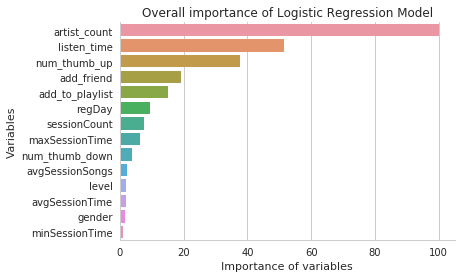

In [143]:
#horizontal bar plot of importance
ax = sns.barplot(data=df, y='Variable', x='importance', orient='h')
plt.xlabel('Importance of variables')
plt.ylabel('Variables')
plt.title('Overall importance of Logistic Regression Model')
sns.despine(ax=ax);

#### Observations:
 - It is evident that the count of artists that a user listens to is the most important variable that will inofrm us the likelihookd of churn of a user 
 - Hence, the top 5 important features are:
     - Number of distinct artists a user listens to
     - Overall time spent listening on the app
     - Number of times the user has voted 'positively'
     - The overall number of friends invited to share the same app
     - The number of songs added to a playlist

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.